<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/%EB%AF%B8%EC%85%985_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import cv2
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from PIL import Image, ImageEnhance, ImageFilter
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
import torch.nn.functional as F

# 미션 설명

## 미션 소개
이번 미션에서는 손상된 문서를 복원하는 작업을 수행합니다. 오토인코더를 활용하여 문서 이미지의 품질을 향상시키고, 문서의 내용을 최대한 복원하는 모델을 구현해 봅시다. 문서는 습기, 찢김, 얼룩 등 다양한 이유로 손상될 수 있는데요. 이번 미션의 목표는 손상된 문서에서 노이즈를 제거하여 원본 문서를 최대한 복원하는 것입니다. 아래 데이터셋을 활용하여 다양한 복원 기법을 실험해보고, 성능을 평가해 보세요.

## 데이터 소개
 - 데이터 링크(Denoising Dirty Documents)
 - train: 손상된 문서(모델 훈련용)
 - train_cleaned: 손상된 문서의 원본(모델 훈련용)
 - test: 손상된 문서(모델 테스트용)

# 데이터 불러오기

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 폴더 경로 설정
train_dirty_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/train"
train_cleaned_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/train_cleaned"
test_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/test"
output_dir = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션5DATA/denoised_results"


array([[[233, 233, 233],
        [234, 234, 234],
        [236, 236, 236],
        ...,
        [231, 231, 231],
        [231, 231, 231],
        [233, 233, 233]],

       [[232, 232, 232],
        [229, 229, 229],
        [229, 229, 229],
        ...,
        [236, 236, 236],
        [235, 235, 235],
        [233, 233, 233]],

       [[221, 221, 221],
        [222, 222, 222],
        [225, 225, 225],
        ...,
        [233, 233, 233],
        [235, 235, 235],
        [236, 236, 236]],

       ...,

       [[218, 218, 218],
        [213, 213, 213],
        [215, 215, 215],
        ...,
        [221, 221, 221],
        [222, 222, 222],
        [228, 228, 228]],

       [[223, 223, 223],
        [223, 223, 223],
        [226, 226, 226],
        ...,
        [226, 226, 226],
        [215, 215, 215],
        [209, 209, 209]],

       [[235, 235, 235],
        [229, 229, 229],
        [226, 226, 226],
        ...,
        [156, 156, 156],
        [ 96,  96,  96],
        [ 61,  61,  61]]], dtype=uint8)
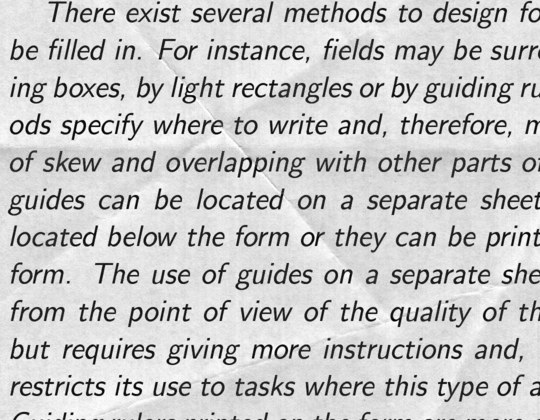

In [7]:
def load_images_from_folder_sorted(folder):
    images = []
    filenames = sorted([f for f in os.listdir(folder) if f.endswith(".png")])
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images, filenames

# 이미지 불러오기
train_dirty_images, dirty_filenames = load_images_from_folder_sorted(train_dirty_dir)
train_cleaned_images, clean_filenames = load_images_from_folder_sorted(train_cleaned_dir)
test_images, test_filenames = load_images_from_folder_sorted(test_dir)

train_dirty_images[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [252, 252, 252],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [242, 242, 242]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [169, 169, 169],
        [ 85,  85,  85],
        [ 31,  31,  31]]], dtype=uint8)
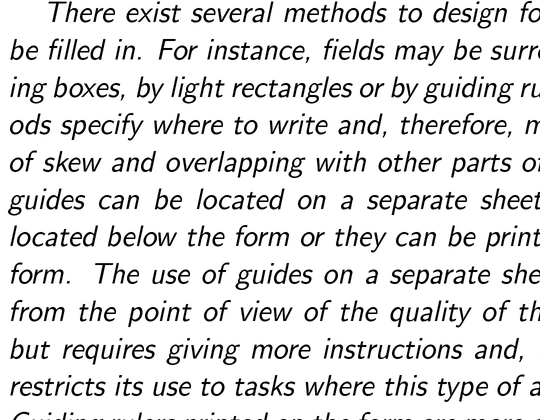

In [8]:
train_cleaned_images[0]

In [9]:
print(train_dirty_images[0].dtype)

uint8


In [10]:
print(len(train_dirty_images))
print(len(train_cleaned_images))
print(len(test_images))

144
144
72


In [11]:
print(type(train_dirty_images[0]))
print(type(train_cleaned_images[0]))
print(type(test_images[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [12]:
# 이미지 데이터 (가장 큰) 사이즈 확인 (목표 패딩 수치 확인용)
def get_unique_sizes(image_list):
    heights = [img.shape[0] for img in image_list]
    widths = [img.shape[1] for img in image_list]
    unique_heights = np.unique(heights)
    unique_widths = np.unique(widths)
    return unique_heights, unique_widths

train_h, train_w = get_unique_sizes(train_dirty_images)
train_cleaned_h, train_cleaned_w = get_unique_sizes(train_cleaned_images)
test_h, test_w = get_unique_sizes(test_images)

max_height = max(np.max(train_h), np.max(train_cleaned_h), np.max(test_h)) + 2
max_width = max(np.max(train_w), np.max(train_cleaned_w), np.max(test_w)) + 2

print(f"패딩 목표 크기: {max_height} x {max_width}")

패딩 목표 크기: 422 x 542


 - 최대값 + 2 => 422 * 542 으로 일괄 이미지 패딩 후 학습 예정

In [13]:
# 전처리 패딩 클래스
class PaddingC:
    def __init__(self, wSize=542, hSize=422, fill=0):
        self.wSize = wSize
        self.hSize = hSize
        self.fill = fill  # padding color

    def pad(self, img):
        # img: PIL Image
        w, h = img.size

        pad_left = max((self.wSize - w) // 2, 0)
        pad_top = max((self.hSize - h) // 2, 0)
        pad_right = max(self.wSize - w - pad_left, 0)
        pad_bottom = max(self.hSize - h - pad_top, 0)

        padding = (pad_left, pad_top, pad_right, pad_bottom)
        padded_img = transforms.functional.pad(img, padding, fill=self.fill)
        return padded_img, padding

## 데이터 셋 생성

In [14]:
# 데이터 셋 설정
class DenoisingDocumentsDataset(Dataset): # 학습용 데이터 셋 클래스
    def __init__(self, train_dirty_images, train_cleaned_images, filenames,
                 transform_padding : PaddingC, transform_gray_to_tensor=None):
        self.train_dirty_images = train_dirty_images
        self.train_cleaned_images = train_cleaned_images
        self.filenames = filenames
        self.transform_padding = transform_padding
        self.transform_gray_to_tensor = transform_gray_to_tensor

    def __len__(self):
        return len(self.train_dirty_images)

    def __getitem__(self, idx):
        dirty_img = Image.fromarray(self.train_dirty_images[idx])
        clean_img = Image.fromarray(self.train_cleaned_images[idx])
        filename = self.filenames[idx]

        dirty_img, dirty_padding = self.transform_padding.pad(dirty_img)
        clean_img, clean_padding = self.transform_padding.pad(clean_img)

        if self.transform_gray_to_tensor is not None:
            dirty_img = self.transform_gray_to_tensor(dirty_img)
            clean_img = self.transform_gray_to_tensor(clean_img)

        return dirty_img, clean_img, filename

class DenoisingTestDataset(Dataset): # 최종 확인 데이터 셋 클래스
    def __init__(self, test_images, filename, transform_padding=None, transform=None):
        self.test_images = test_images
        self.filename = filename
        self.transform_padding = transform_padding
        self.transform = transform

    def __len__(self):
        return len(self.test_images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.test_images[idx])
        filename = self.filename[idx]

        # 패딩 적용 (transform_padding이 있으면)
        if self.transform_padding is not None:
            img, _ = self.transform_padding.pad(img)

        if self.transform:
            img = self.transform(img)

        return img, filename

In [15]:
pad_transform = PaddingC(wSize=542, hSize=422, fill=0)

grayscale = transforms.Grayscale(num_output_channels=1)
to_tensor = transforms.ToTensor()

transform = transforms.Compose([
    grayscale,
    to_tensor,
])

dataset = DenoisingDocumentsDataset(
    train_dirty_images,
    train_cleaned_images,
    dirty_filenames,
    transform_padding=pad_transform,
    transform_gray_to_tensor=transform,
)

test_dataset = DenoisingTestDataset(
    test_images,
    test_filenames,
    transform_padding=pad_transform,
    transform=transform,
)

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 학습 데이터shape 확인
dirty_img, clean_img, filename = dataset[0]
print(dirty_img.shape, clean_img.shape)

# 테스트 데이터shape 확인
test_img, filename = test_dataset[0]

print(test_img.shape)

print(f"전체 데이터셋 크기: {len(dataset)}")
print(f"결과적용 데이터셋 크기: {len(test_dataset)}")


torch.Size([1, 422, 542]) torch.Size([1, 422, 542])
torch.Size([1, 422, 542])
전체 데이터셋 크기: 144
결과적용 데이터셋 크기: 72


In [16]:
# 학습 데이터 셋 -> 학습 / 검증 으로 나눠두기

total_size = len(dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")

학습 데이터셋 크기: 116
검증 데이터셋 크기: 28


# 모델링
- AutoEncoder
- CNN 구조 기반

- 1차 모델링: 1 -> 32 -> 64 -> 128 -> 64 -> 32 -> 1
결과: 에폭 20~ 이후 기울기 변화가 0.0005에서 거의 없음. 오히려 val 쪽이 미세하게 들쑥 날쑥.

  -> 결과적으로 일반화 성능을 강화하는게 좋을듯.

- 2차 모델링: 일반화 대응을 위해 dropout 추가

- 3차 모델링: 특징 강화를 위해 디코더시퀀서 끝단에 시그모이드 추가

- 4차 모델링: BatchNorm2d 추가

- 5차 모델링: 인코더 끝단, 디코더 첫단에 128 -> 128 Conv2d 레이어 추가. 커널 1, 패딩 0

- 6차 모델링: dropout 수치 조정

In [17]:
# 모델 설계
class Model_CNN(nn.Module):
    def __init__(self):
        super(Model_CNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 입력 1 → 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 → 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.13),

            nn.Conv2d(128, 128, kernel_size=1, padding=0), # 128 → 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, padding=0), # 128 → 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),

            nn.Conv2d(128, 64, kernel_size=3, padding=1), # 128 → 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, padding=1), # 64 → 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),  # 32 → 1
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 학습 진행

In [18]:
# 하이퍼파라미터
EPOCHS = 50
LEARNING_RATE = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()  # MSE

print(f"Using device: {device}")

Using device: cuda


In [19]:
# 학습
model = Model_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam

for epoch in range(EPOCHS):
    running_loss = 0.0

    model.train()
    for dirty, clean, filename in train_loader:
        dirty, clean = dirty.to(device), clean.to(device)

        optimizer.zero_grad()
        output = model(dirty)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    val_results = []
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for dirty, clean, filename in val_loader:
            dirty, clean = dirty.to(device), clean.to(device)
            output = model(dirty)
            loss = criterion(output, clean)
            val_loss += loss.item()

            # 검증 출력용
            val_results.extend([
                (d.cpu(), c.cpu(), o.cpu(), fn)
                for d, c, o, fn in zip(dirty, clean, output, filename)
            ])

    avg_val_loss = val_loss / len(val_loader)

    if epoch % 5 == 0:
        print(f"[Epoch {epoch+1}/{EPOCHS}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | TL - VL: {(running_loss - val_loss):.4f}")
    elif epoch+1 == EPOCHS:
        print(f"[Epoch {epoch+1}/{EPOCHS}] "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | TL - VL: {(running_loss - val_loss):.4f}")

[Epoch 1/50] Train Loss: 0.0552 | Val Loss: 0.1504 | TL - VL: 0.2260
[Epoch 6/50] Train Loss: 0.0022 | Val Loss: 0.0017 | TL - VL: 0.0259
[Epoch 11/50] Train Loss: 0.0020 | Val Loss: 0.0011 | TL - VL: 0.0251
[Epoch 16/50] Train Loss: 0.0011 | Val Loss: 0.0007 | TL - VL: 0.0136
[Epoch 21/50] Train Loss: 0.0009 | Val Loss: 0.0009 | TL - VL: 0.0102
[Epoch 26/50] Train Loss: 0.0008 | Val Loss: 0.0006 | TL - VL: 0.0101
[Epoch 31/50] Train Loss: 0.0007 | Val Loss: 0.0006 | TL - VL: 0.0081
[Epoch 36/50] Train Loss: 0.0007 | Val Loss: 0.0007 | TL - VL: 0.0070
[Epoch 41/50] Train Loss: 0.0006 | Val Loss: 0.0008 | TL - VL: 0.0058
[Epoch 46/50] Train Loss: 0.0005 | Val Loss: 0.0005 | TL - VL: 0.0058
[Epoch 50/50] Train Loss: 0.0006 | Val Loss: 0.0004 | TL - VL: 0.0079


## 모델 검증 시각화

In [20]:
# 원본 vs 클린(학습용) vs 결과(검증)
def show_val_results(val_results, num_samples=3):
    samples = random.sample(val_results, num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(9, num_samples * 3))
    if num_samples == 1:
        axes = [axes]

    for i, (dirty_img, clean_img, pred_img, filename) in enumerate(samples):
        dirty_img = dirty_img.squeeze().numpy()
        clean_img = clean_img.squeeze().numpy()
        pred_img = pred_img.squeeze().numpy()

        # 원본
        axes[i][0].imshow(dirty_img, cmap='gray')
        axes[i][0].set_title(f"Dirty({filename})")
        axes[i][0].axis("off")

        axes[i][1].imshow(clean_img, cmap='gray')
        axes[i][1].set_title("Clean")
        axes[i][1].axis("off")

        axes[i][2].imshow(pred_img, cmap='gray')
        axes[i][2].set_title("Predicted")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()

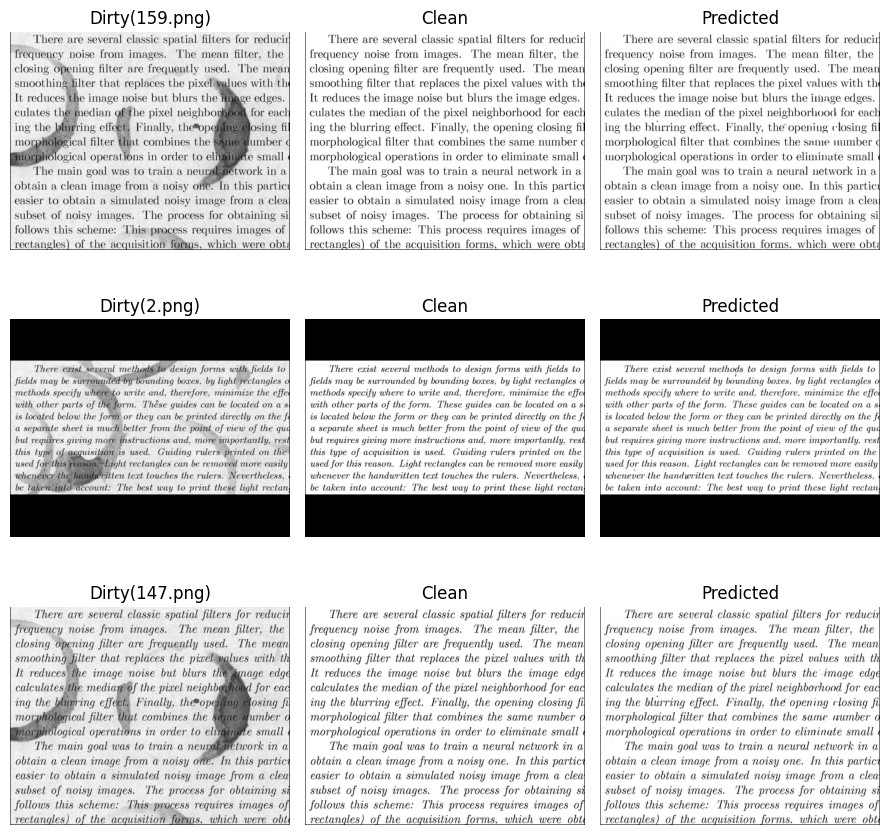

In [25]:
# 랜덤 샘플 = 3
show_val_results(val_results, num_samples=3)

# 결과 확인

In [22]:
# 결과 이미지 저장
os.makedirs(output_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for img, filename in test_loader:
        img = img.to(device)
        output = model(img)
        output = output.cpu()

        for i in range(output.size(0)):
            denoised = output[i]
            # tensor -> PIL 이미지 변환
            denoised_pil = TF.to_pil_image(denoised.squeeze())
            denoised_pil.save(os.path.join(output_dir, f"{filename[i]}"))


In [23]:
# 원본 vs 디노이즈드 시각화 (랜덤 샘플 = 2)
def show_denoised_results(output_dir, test_dir, num_samples=2):
    sample_files = random.sample(os.listdir(output_dir), 2)

    fig, axes = plt.subplots(len(sample_files), 2, figsize=(10, 10))

    for i, sf in enumerate(sample_files):
        # 변환 이미지
        output_img_path = os.path.join(output_dir, sf)
        output_img = Image.open(output_img_path)

        # 원본 이미지
        original_img_path = os.path.join(test_dir, sf)
        original_img = Image.open(original_img_path)

        # 원본 표시
        axes[i][0].imshow(original_img, cmap='gray')
        axes[i][0].set_title(f"Original({sf})")
        axes[i][0].axis("off")

        # 변환 후 표시
        axes[i][1].imshow(output_img, cmap='gray')
        axes[i][1].set_title(f"Denoised({sf})")
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

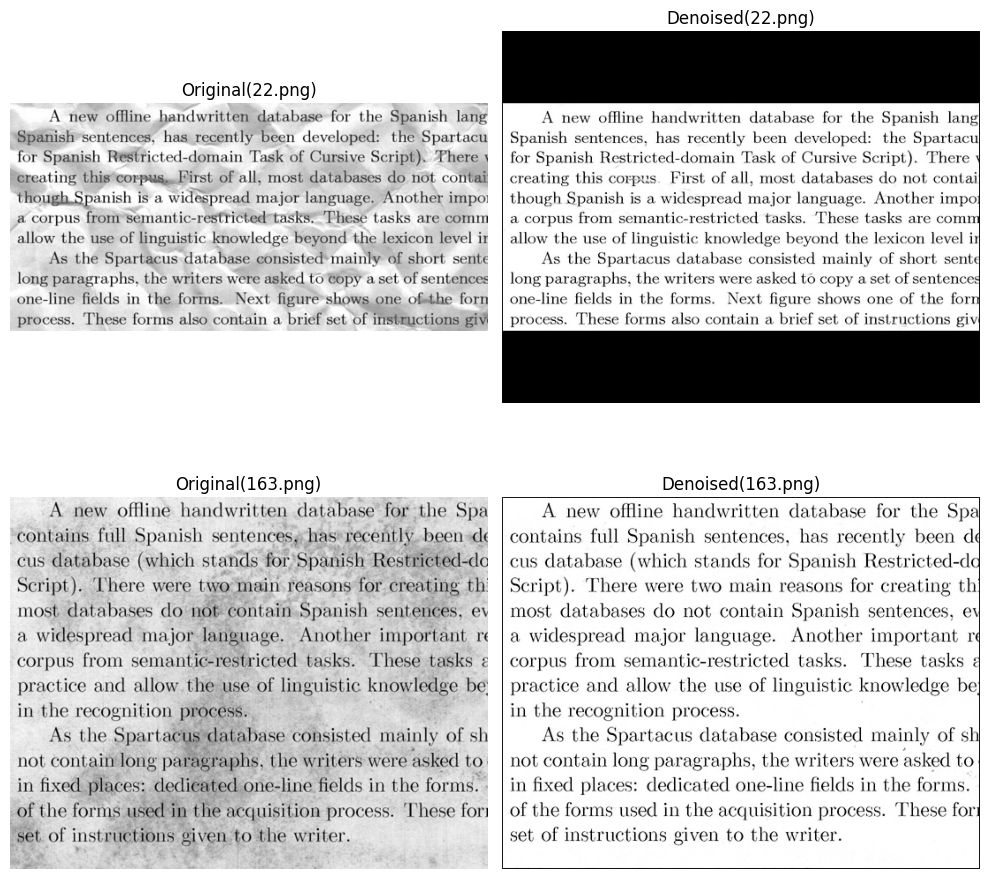

In [33]:
show_denoised_results(output_dir, test_dir, num_samples=2)

# 모델 서머리

In [34]:
!pip install torchinfo

In [36]:
from torchinfo import summary
summary(model, input_size=(8, 1, 422, 542))

Layer (type:depth-idx)                   Output Shape              Param #
Model_CNN                                [8, 1, 422, 542]          --
├─Sequential: 1-1                        [8, 128, 422, 542]        --
│    └─Conv2d: 2-1                       [8, 32, 422, 542]         320
│    └─BatchNorm2d: 2-2                  [8, 32, 422, 542]         64
│    └─ReLU: 2-3                         [8, 32, 422, 542]         --
│    └─Conv2d: 2-4                       [8, 64, 422, 542]         18,496
│    └─BatchNorm2d: 2-5                  [8, 64, 422, 542]         128
│    └─ReLU: 2-6                         [8, 64, 422, 542]         --
│    └─Dropout: 2-7                      [8, 64, 422, 542]         --
│    └─Conv2d: 2-8                       [8, 128, 422, 542]        73,856
│    └─BatchNorm2d: 2-9                  [8, 128, 422, 542]        256
│    └─ReLU: 2-10                        [8, 128, 422, 542]        --
│    └─Dropout: 2-11                     [8, 128, 422, 542]        --
│   